In [72]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();
import libactive; reload(libactive)
import matplotlib.pyplot as plt
import math
import seaborn as sns
from libplot import align_yaxis

In [2]:
cm = sns.color_palette('gist_ncar', 7, desat=0.4)

In [3]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("anuran", wrap(anuran, None)),
        #("avila", wrap(avila, None)),
        #("covertype", wrap(covertype, None)),
        #("rcv1", wrap(rcv1, None)),
        #("sensorless", wrap(sensorless, None)),
        ("spamassassin", wrap(spamassassin, None)),
        #("splice", wrap(splice, None)),
        #("swarm", wrap(swarm, None)),
        #("smartphone", wrap(smartphone, None))
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("res500", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [4]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-ee8e14ca-e310-4eeb-9957-0109a09e2de0.json']
Current commit: 9d93dd0



Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
results_plots[0][1][0].columns

Index(['x', 'accuracy_score', 'f1_score', 'roc_auc_score', 'time',
       'uncertainty_average', 'uncertainty_min', 'uncertainty_max',
       'uncertainty_variance', 'uncertainty_average_selected',
       'uncertainty_min_selected', 'uncertainty_max_selected',
       'uncertainty_variance_selected', 'entropy_max', 'n_support',
       'contradictory_information', 'expected_error', 'expected_error_min',
       'expected_error_max', 'expected_error_average',
       'expected_error_variance'],
      dtype='object')

### List of stopping conditions & metrics to compute

In [5]:
reload(libstop); from libstop import *
def acc_wrapper(**kwargs):
    x, diffs = first_acc(**kwargs)
    return [np.nan] +diffs

stuff = {
    #'GOAL': [partial(ZPS, order=2), acc_wrapper, None], 
    #'SSNCut': [SSNCut, SSNCut_values, None], 
    #'SC_entropy_mcs': [SC_entropy_mcs, 'entropy_max', 1e-2], 
    #'SC_oracle_acc': [SC_oracle_acc_mcs, SC_oracle_acc_mcs_values, 0.9], 
    #'SC_mes': [SC_mes, 'expected_error_min', 1e-2], 
    'Stabilizing Predictions': [stabilizing_predictions, kappa_metric, 0.99], 
    'Performance Convergence': [performance_convergence, fscore, None], 
    #'Uncertainty Convergence': [uncertainty_convergence, partial(metric_selected, metric=classifier_entropy), None], 
    #'Max Confidence': [max_confidence, partial(metric_selected, metric=classifier_entropy), 1e-3],
    #'EVM': [EVM, 'uncertainty_variance_selected', None], 
    #'VM': [VM, 'uncertainty_variance_selected', None], 
    #'N support vectors': [None, 'n_support', None], 
    #'Contradictory Information': [contradictory_information, 'contradictory_information', None], 
    #'Kappa First': [None, kappa_metric_first, None],
    'Classification Change': [classification_change, classification_change_values, 1],
    'Overall Uncertainty': [overall_uncertainty, 'uncertainty_average', 1e-2]
}

conditions = [x[0] for x in stuff.values()]
metric_values = [x[1] for x in stuff.values()]
thresholds = [x[2] for x in stuff.values()]
names = list(stuff.keys())

### Create the unlabelled pools

In [6]:
results = results_plots[0][1]
conf = results_plots[0][0]
X, y = getattr(libdatasets, conf.dataset_name)(None)
unlabelled_pools = []
y_oracles = []
# WARN: This is not the same as the job numbers! Unfortunately they're not easily accessible
for i in range(len(results)):
    _, X_unlabelled, _, Y_oracle, _, _ = active_split(
        X, y, labeled_size=conf.meta['labelled_size'], test_size=conf.meta['test_size'], random_state=check_random_state(i), ensure_y=conf.meta['ensure_y']
    )
    unlabelled_pools.append(X_unlabelled)
    y_oracles.append(Y_oracle)

### Evaluate the metrics

In [7]:
computed = {}

In [8]:
#del computed['Performance Convergence']

In [9]:
for metric, name in zip(metric_values, names):
    if name in computed:
        continue
    if isinstance(metric, str):
        values = np.array([results[i][metric] for i in range(len(results))])
    else:
        values = np.array([metric(**results[i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])

    computed[name] = values

In [12]:
#computed['Performance Convergence'] = np.array([list(computed['Performance Convergence'][i]) for i in range(len(computed['Performance Convergence']))])
#computed['Uncertainty Convergence'] = np.array([list(computed['Uncertainty Convergence'][i]) for i in range(len(computed['Uncertainty Convergence']))])
#computed['Max Confidence'] = np.array([list(computed['Max Confidence'][i]) for i in range(len(computed['Max Confidence']))])

In [44]:
computed['Stabilizing Predictions'][0][2:];

In [39]:
np.argmax(np.logical_not(np.isnan(computed['Stabilizing Predictions'][0])))

2

### Calculate the derivatives

In [53]:
computed_derivatives = {}
for name, runs in computed.items():
    computed_derivatives[name] = []
    for run in runs:
        n = np.argmax(np.logical_not(np.isnan(run)))
        computed_derivatives[name].append(
            [*[np.nan]*n, *no_ahead_tvregdiff(run[n:], 1, 1e-1, plotflag=False, diagflag=False)]
        )

In [54]:
print(computed_derivatives)

{'Stabilizing Predictions': [[nan, nan, nan, nan, 0.015342167382860872, -0.015626226411232833, -0.012692440666733355, -0.09493560548057856, -0.13726332870522734, -0.10343768887545107, -0.04357255354024264, 0.015559908948663187, 0.055670417205725305, 0.05338612068730658, 0.07815666058501722, 0.07275513400769681, -0.1153658791086889, -0.23591810281990172, -0.07583988583841528, 0.07093580326874893, 0.008848892178869194, 0.029312619333496548, 0.0752395816157573, 0.08048320933469097, 0.15359849032174666, 0.1866544606397901, 0.22320140917751322, 0.23956457594166616, 0.2527595847995207, 0.2693962414556841, 0.27115329903942886, 0.2570155731936347, 0.2405461055768516, 0.22215889771935532, 0.2037576095576997, 0.1892991057013627, 0.1812736702340572, 0.17025421573865518, 0.15796173522791054, 0.1440206074104825, 0.13035555325850273, 0.11745073045245953, 0.09010771752318061, 0.08436470899698756, 0.07810492966614245, 0.07189264522433894, 0.09326035090415326, 0.19570752512718015, -0.1684341066619059, 

### Evaluate the conditions

In [19]:
computed_conds = {}

In [20]:
for cond, name in zip(conditions, names):
    if name in computed_conds:
        continue
    if cond is None:
        values = [None] * len(values)
    else:
        try:
            values = np.array([cond(**results[i], pre=computed[name][i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])
        except FailedToTerminate:
            values = [None] * len(results)
    computed_conds[name] = values

In [21]:
list(computed_conds.keys())

['Stabilizing Predictions',
 'Performance Convergence',
 'Classification Change',
 'Overall Uncertainty']

### Create the plot

In [22]:
import seaborn as sns
cm = sns.color_palette('gist_ncar', 7, desat=0.4)

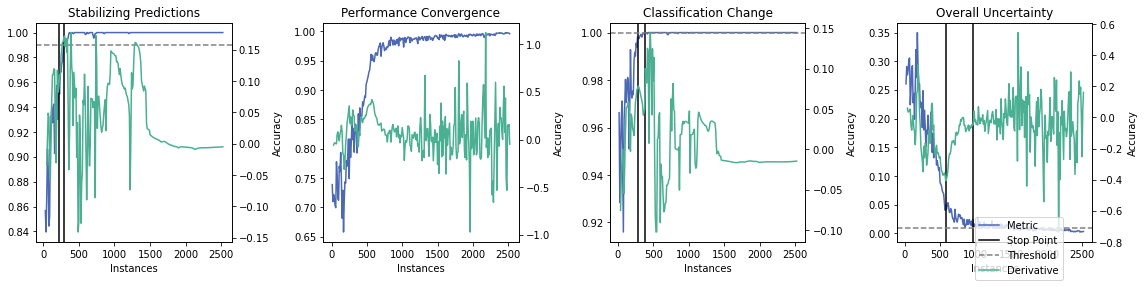

In [56]:
fig = plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=10, hspace=0.3)
from matplotlib.gridspec import GridSpec
gs = fig.add_gridspec(1,4)
threshold_legend = True
stop_legend = True
for j, (metric, name, threshold) in enumerate(zip(metric_values, names, thresholds)):
    x = j%5
    ax = fig.add_subplot(gs[0, j])
        
    values = computed[name]
    derivative = computed_derivatives[name]
        
    ax.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(values, axis=0), color=cm[0], label="Metric" if j == 0 else None)
    
    
    for stop in computed_conds[name]:
        if stop is None:
            continue
        ax.axvline(stop, color='black', label='Stop Point' if stop_legend else None)
        stop_legend = False
        
    if threshold is not None:
        ax.axhline(threshold, color='gray', ls='--', label='Threshold' if threshold_legend else None)
        threshold_legend = False
    
    ax2 = ax.twinx()
    #ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), color=cm[6], label="Accuracy" if j == 0 else None)
    #ax2.plot(results[0].x, np.mean(np.array([results[i]['f1_score'] for i in range(len(results))]), axis=0), color=cm[2], label="F1 Score" if j == 0 else None)
    ax2.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(derivative, axis=0), color=cm[1], label="Derivative" if j == 0 else None)

    ax2.set_ylabel('Accuracy')
    ax.set_title(name)
    
    #if j != 3:
        #ax2.axes.get_yaxis().set_visible(False)
    
    ax.set_xlabel("Instances")
       

fig.legend(bbox_to_anchor=(0.93, 0.25))
fig.tight_layout()

## Varied regularlization

In [63]:
def derive(eps, diffkernel='abs'):
    computed_derivatives = {}
    for name, runs in computed.items():
        computed_derivatives[name] = []
        for run in runs:
            n = np.argmax(np.logical_not(np.isnan(run)))
            computed_derivatives[name].append(
                [*[np.nan]*n, *no_ahead_tvregdiff(run[n:], 1, eps, plotflag=False, diagflag=False, diffkernel=diffkernel)]
            )
    return computed_derivatives

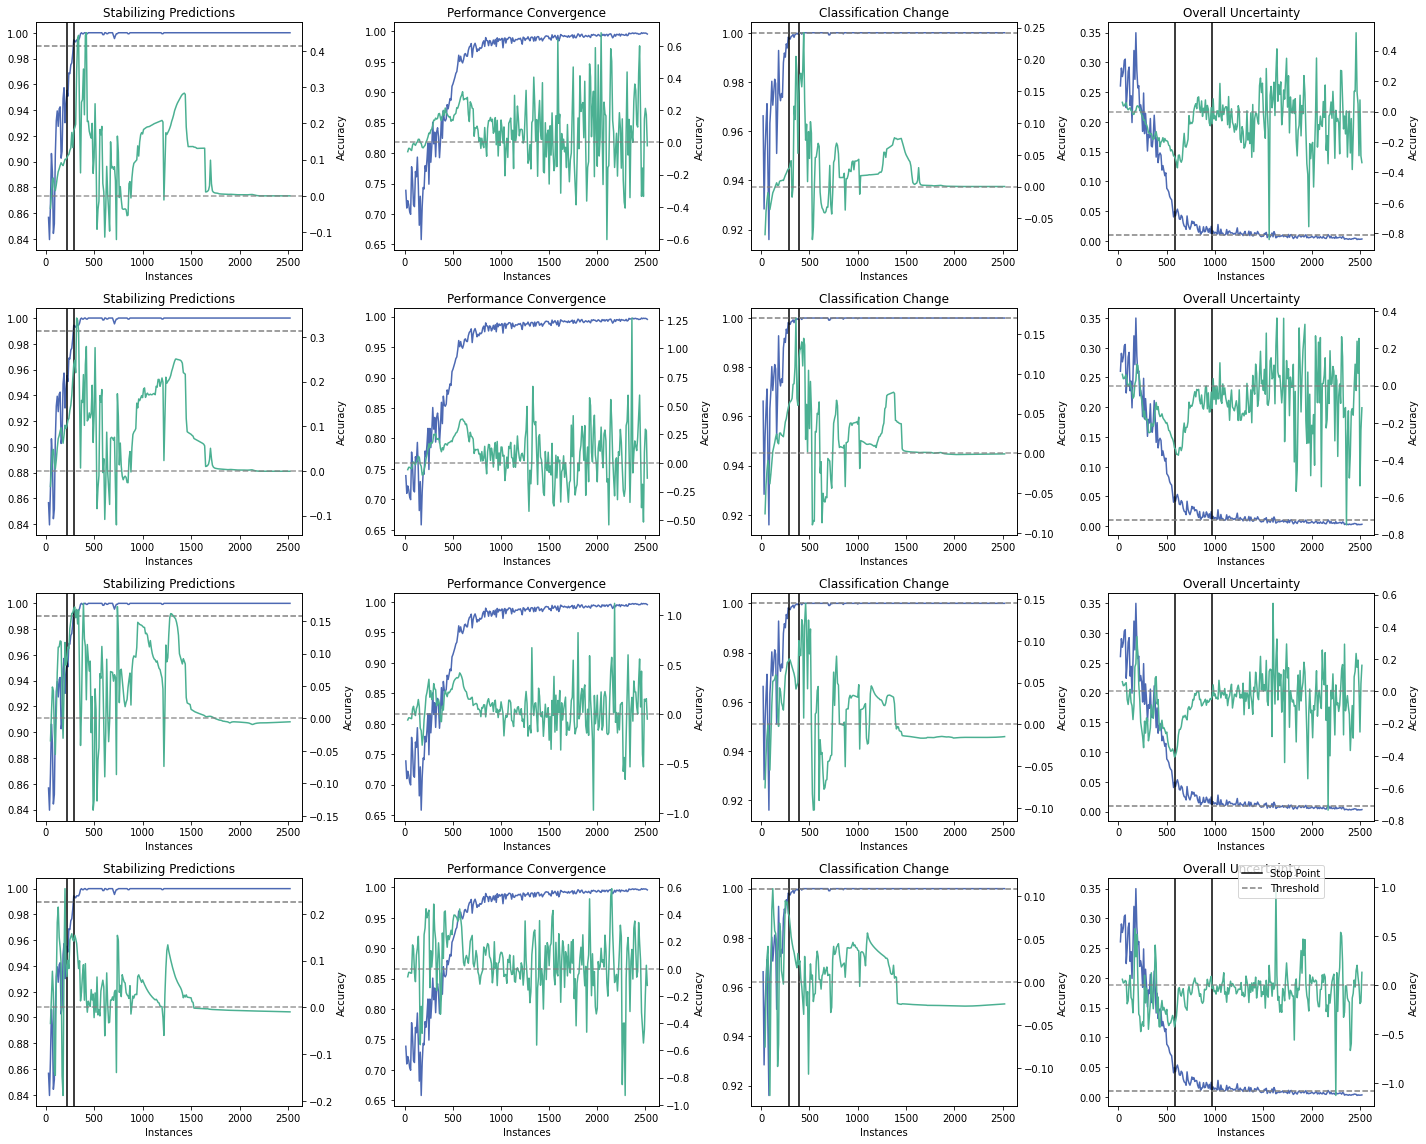

In [62]:
fig = plt.figure(figsize=(20,16))
plt.subplots_adjust(wspace=10, hspace=0.3)
from matplotlib.gridspec import GridSpec
gs = fig.add_gridspec(4,4)
threshold_legend = True
stop_legend = True
for C, EPS in enumerate([10, 1, 1e-1, 1e-2]):
    derivatives = derive(EPS, diffkernel='sq')
    for j, (metric, name, threshold) in enumerate(zip(metric_values, names, thresholds)):
        x = j%5
        ax = fig.add_subplot(gs[C, j])

        values = computed[name]
        derivative = derivatives[name]
        

        ax.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(values, axis=0), color=cm[0], label="Metric" if j == 0 and C ==0 else None)


        for stop in computed_conds[name]:
            if stop is None:
                continue
            ax.axvline(stop, color='black', label='Stop Point' if stop_legend else None)
            stop_legend = False

        if threshold is not None:
            ax.axhline(threshold, color='gray', ls='--', label='Threshold' if threshold_legend else None)
            threshold_legend = False

        ax2 = ax.twinx()
        #ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), color=cm[6], label="Accuracy" if j == 0 else None)
        #ax2.plot(results[0].x, np.mean(np.array([results[i]['f1_score'] for i in range(len(results))]), axis=0), color=cm[2], label="F1 Score" if j == 0 else None)
        ax2.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(derivative, axis=0), color=cm[1], label="Derivative" if j == 0 and C ==0 else None)
        ax2.axhline(0, color='grey', ls='--', alpha=0.8)

        ax2.set_ylabel('Accuracy')
        ax.set_title(name)

        #if j != 3:
            #ax2.axes.get_yaxis().set_visible(False)

        ax.set_xlabel("Instances")


fig.legend(bbox_to_anchor=(0.93, 0.25))
fig.tight_layout()

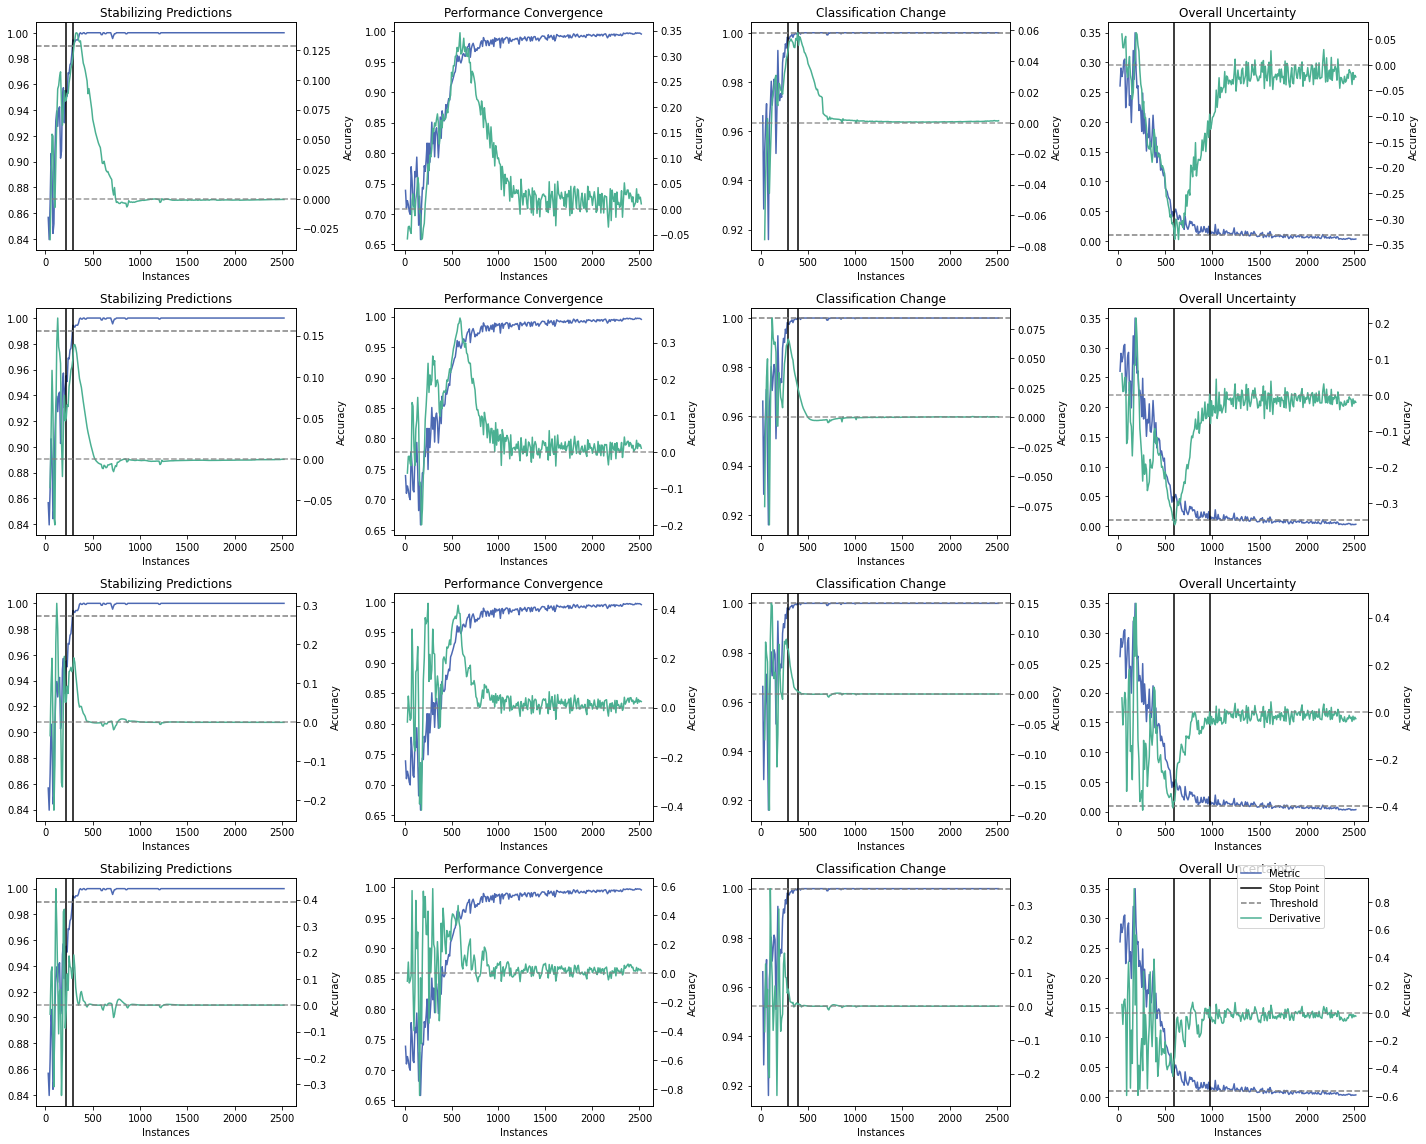

In [66]:
fig = plt.figure(figsize=(20,16))
plt.subplots_adjust(wspace=10, hspace=0.3)
from matplotlib.gridspec import GridSpec
gs = fig.add_gridspec(4,4)
threshold_legend = True
stop_legend = True
for C, EPS in enumerate([1e-1, 1e-2, 1e-3, 1e-4]):
    derivatives = derive(EPS, diffkernel='sq')
    for j, (metric, name, threshold) in enumerate(zip(metric_values, names, thresholds)):
        x = j%5
        ax = fig.add_subplot(gs[C, j])

        values = computed[name]
        derivative = derivatives[name]
        

        ax.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(values, axis=0), color=cm[0], label="Metric" if j == 0 and C ==0 else None)


        for stop in computed_conds[name]:
            if stop is None:
                continue
            ax.axvline(stop, color='black', label='Stop Point' if stop_legend else None)
            stop_legend = False

        if threshold is not None:
            ax.axhline(threshold, color='gray', ls='--', label='Threshold' if threshold_legend else None)
            threshold_legend = False

        ax2 = ax.twinx()
        #ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), color=cm[6], label="Accuracy" if j == 0 else None)
        #ax2.plot(results[0].x, np.mean(np.array([results[i]['f1_score'] for i in range(len(results))]), axis=0), color=cm[2], label="F1 Score" if j == 0 else None)
        ax2.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(derivative, axis=0), color=cm[1], label="Derivative" if j == 0 and C ==0 else None)
        ax2.axhline(0, color='grey', ls='--', alpha=0.8)

        ax2.set_ylabel('Accuracy')
        ax.set_title(name)

        #if j != 3:
            #ax2.axes.get_yaxis().set_visible(False)

        ax.set_xlabel("Instances")


fig.legend(bbox_to_anchor=(0.93, 0.25))
fig.tight_layout()

In [67]:
def derive_vals(run, eps=1e-1, diffkernel='abs'):
    n = np.argmax(np.logical_not(np.isnan(run)))
    return [*[np.nan]*n, *no_ahead_tvregdiff(run[n:], 1, eps, plotflag=False, diagflag=False, diffkernel=diffkernel)]

In [77]:
derivatives = derive(1e-1, diffkernel='sq')
seconds = [derive_vals(derivative[0], eps=EPS, diffkernel='sq') for EPS in [10, 1, 1e-1, 1e-2]]

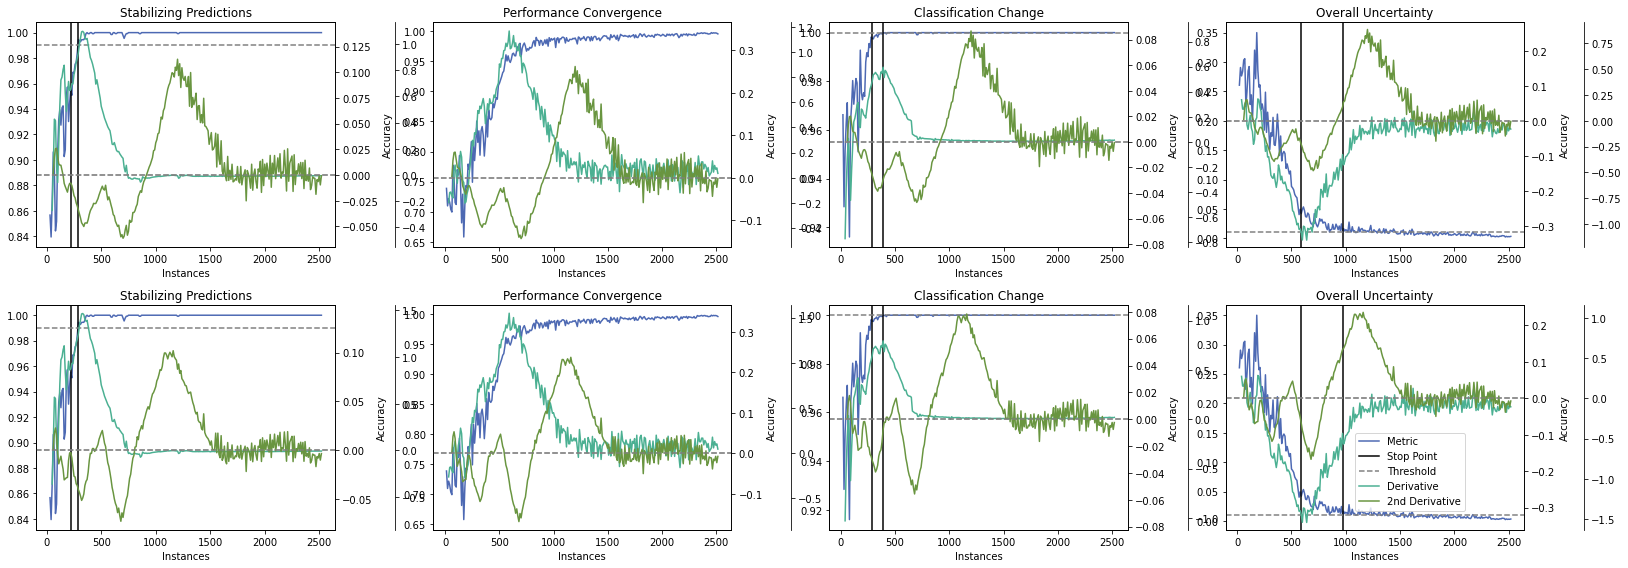

In [80]:
fig = plt.figure(figsize=(22,8))
plt.subplots_adjust(wspace=10, hspace=0.3)
from matplotlib.gridspec import GridSpec
gs = fig.add_gridspec(2,4)
threshold_legend = True
stop_legend = True

for C, second in enumerate(seconds[2:3]):
    for j, (metric, name, threshold) in enumerate(zip(metric_values, names, thresholds)):
        x = j%5
        ax = fig.add_subplot(gs[C, j])

        values = computed[name]
        derivative = derivatives[name]
        

        ax.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(values, axis=0), color=cm[0], label="Metric" if j == 0 and C ==0 else None)


        for stop in computed_conds[name]:
            if stop is None:
                continue
            ax.axvline(stop, color='black', label='Stop Point' if stop_legend else None)
            stop_legend = False

        if threshold is not None:
            ax.axhline(threshold, color='gray', ls='--', label='Threshold' if threshold_legend else None)
            threshold_legend = False

        ax2 = ax.twinx()
        #ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), color=cm[6], label="Accuracy" if j == 0 else None)
        #ax2.plot(results[0].x, np.mean(np.array([results[i]['f1_score'] for i in range(len(results))]), axis=0), color=cm[2], label="F1 Score" if j == 0 else None)
        ax2.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], np.mean(derivative, axis=0), color=cm[1], label="Derivative" if j == 0 and C ==0 else None)
        
        ax2.axhline(0, color='grey', ls='--', alpha=0.8)
        
        ax3 = ax.twinx()

        # Offset the right spine of twin2.  The ticks and label have already been
        # placed on the right by twinx above.
        ax3.spines.right.set_position(("axes", 1.2))
        
        ax3.plot(results[0].x[results[0].x.shape[0]-values[0].shape[0]:], second, color=cm[2], label="2nd Derivative" if j == 0 and C ==0 else None)
        
        ax3.axhline(0, color='grey', ls='--', alpha=0.8)
        
        align_yaxis(ax2, ax3)

        ax2.set_ylabel('Accuracy')
        ax.set_title(name)

        #if j != 3:
            #ax2.axes.get_yaxis().set_visible(False)

        ax.set_xlabel("Instances")


fig.legend(bbox_to_anchor=(0.93, 0.25))
fig.tight_layout()

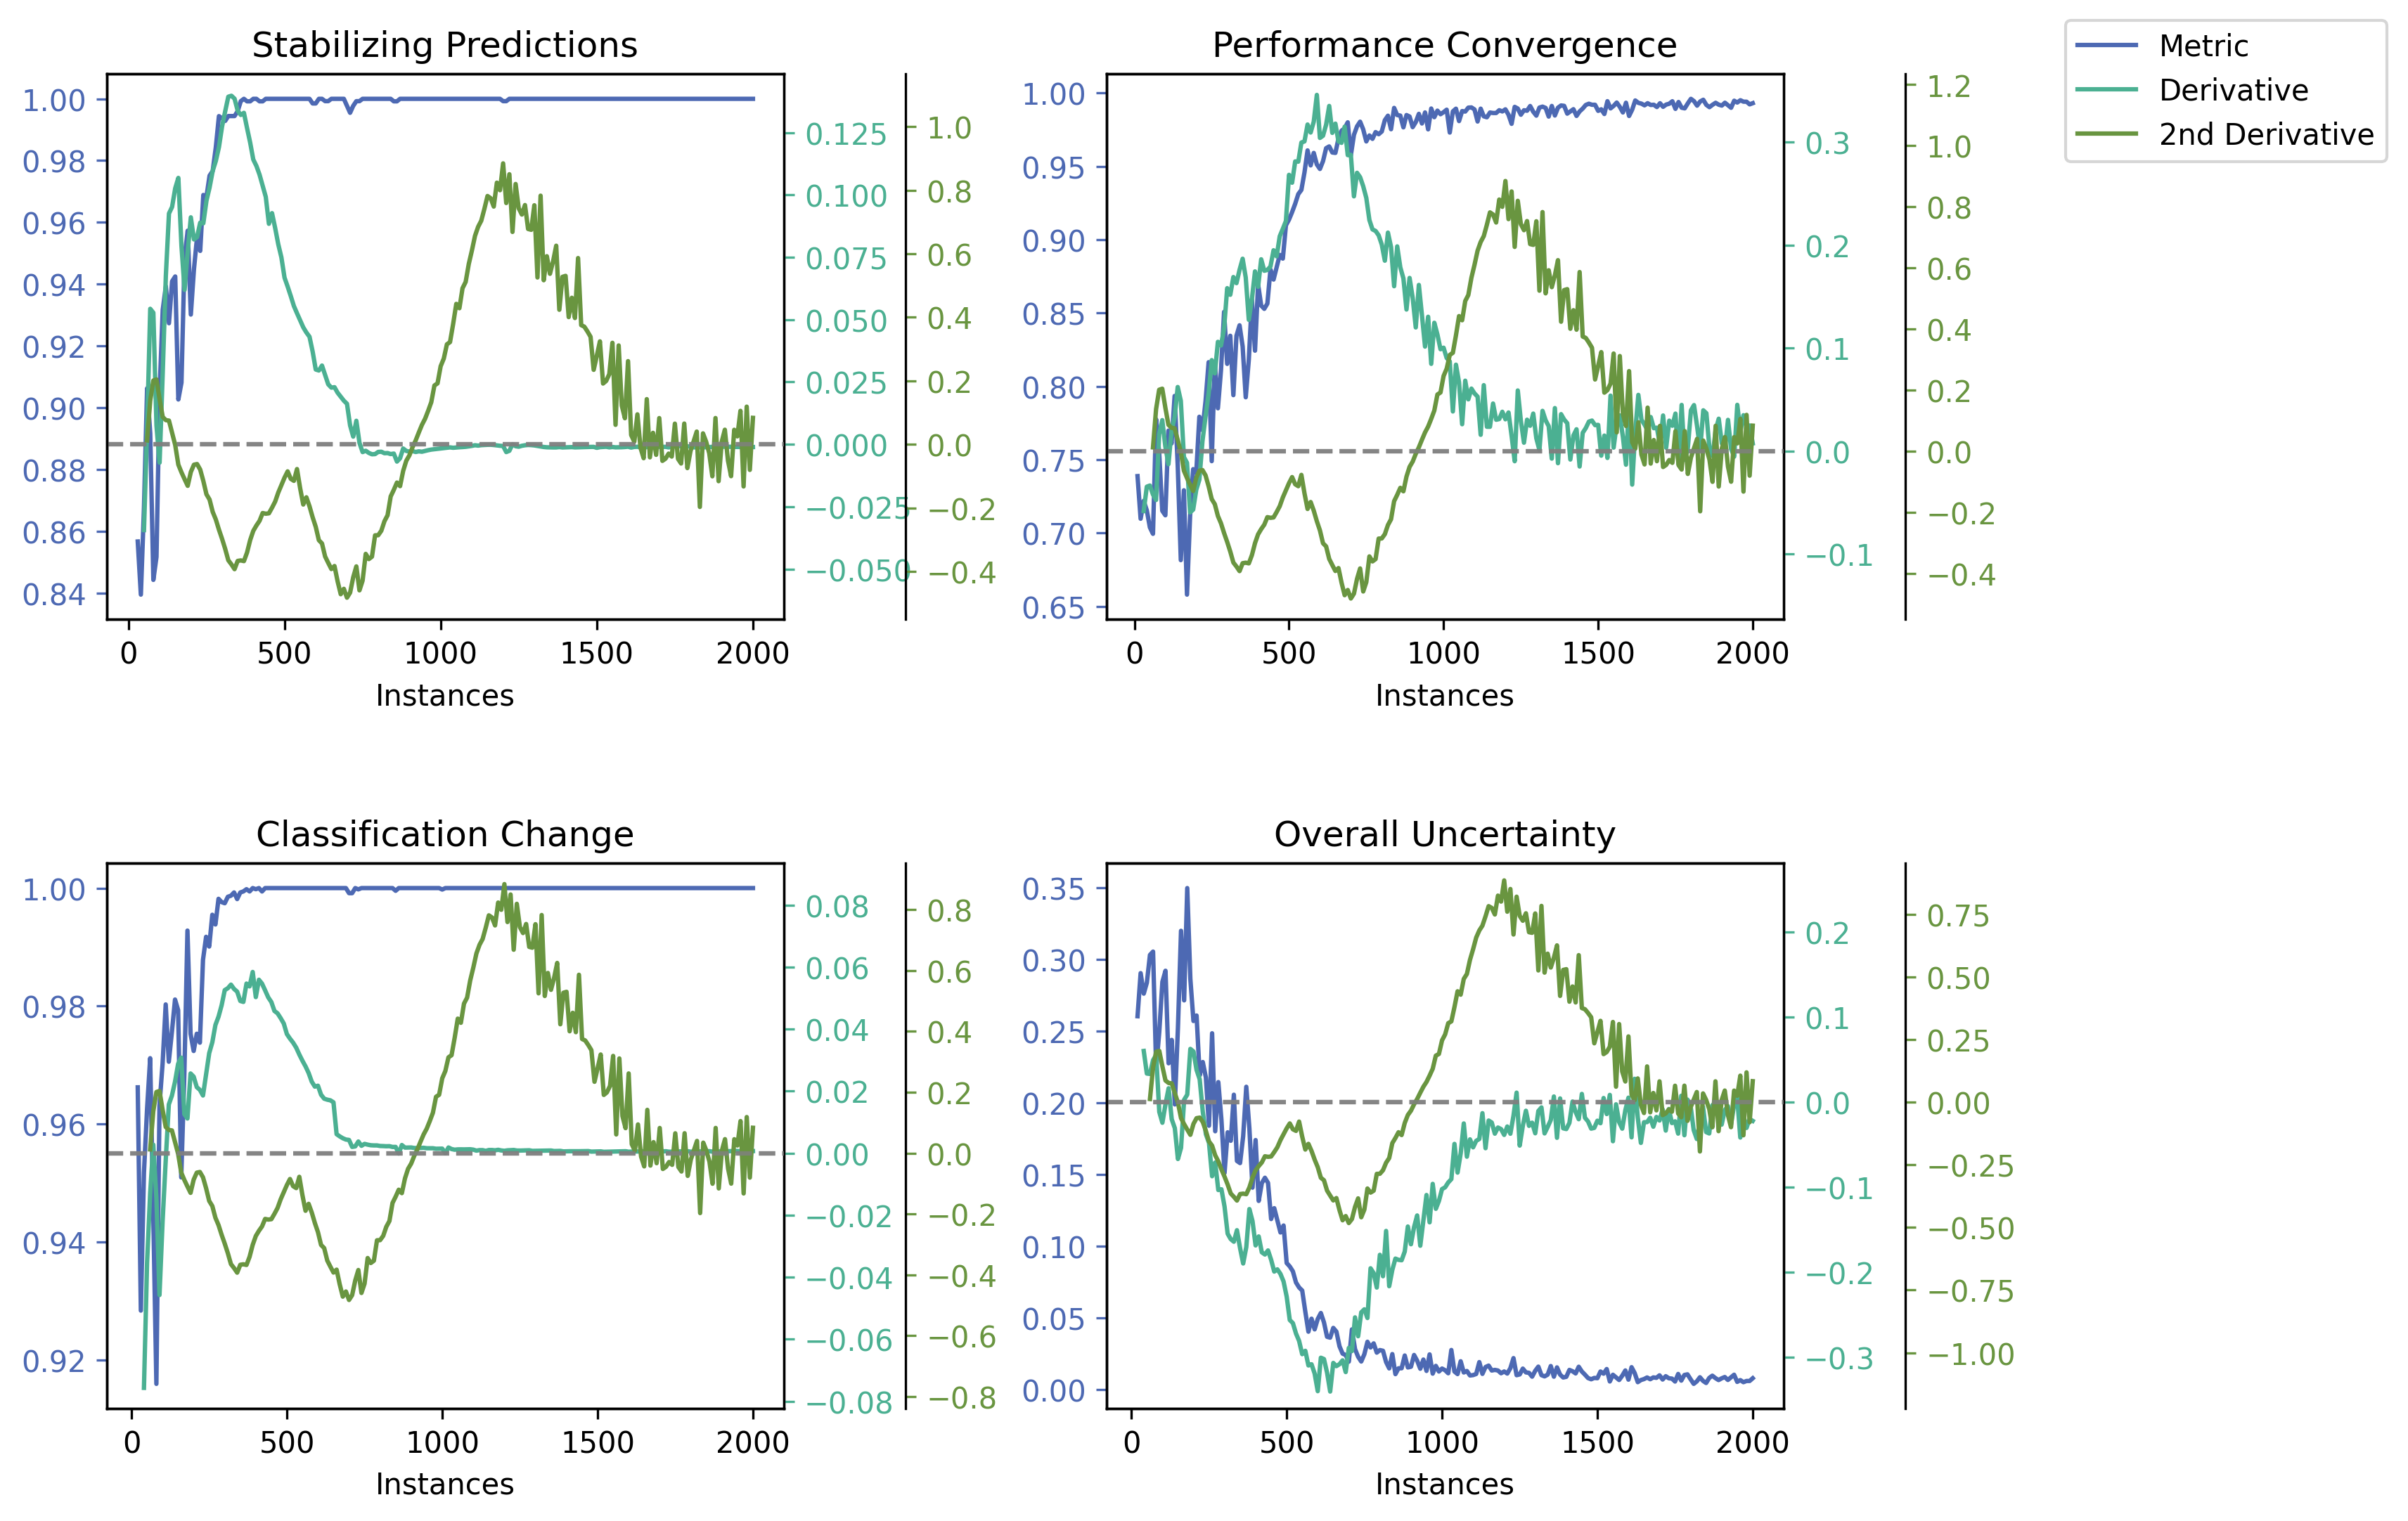

In [180]:
fig = plt.figure(figsize=(10,8), dpi=300)
plt.subplots_adjust(wspace=10, hspace=0.3)
from matplotlib.gridspec import GridSpec
gs = fig.add_gridspec(2,2)
threshold_legend = True
stop_legend = True

for C, second in enumerate(seconds[2:3]):
    for j, (metric, name, threshold) in enumerate(zip(metric_values, names, thresholds)):
        x = j%5
        ax = fig.add_subplot(gs[j//2, j%2])
        fig.subplots_adjust(right=0.75)

        values = np.array(computed[name])
        derivative = np.array(derivatives[name])[:,:200]
        x = results[0].x[results[0].x.shape[0]-values.shape[1]:][:200]
        values = values[:,:200]
        
        ax.plot(x, np.mean(values, axis=0), color=cm[0], label="Metric" if j == 0 and C ==0 else None)


        for stop in computed_conds[name]:
            if stop is None:
                continue
            #ax.axvline(stop, color='black', label='Stop Point' if stop_legend else None)
            stop_legend = False

        if threshold is not None:
            #ax.axhline(threshold, color='gray', ls='--', label='Threshold' if threshold_legend else None)
            threshold_legend = False

        ax2 = ax.twinx()
        #ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), color=cm[6], label="Accuracy" if j == 0 else None)
        #ax2.plot(results[0].x, np.mean(np.array([results[i]['f1_score'] for i in range(len(results))]), axis=0), color=cm[2], label="F1 Score" if j == 0 else None)
        ax2.plot(x, np.mean(derivative, axis=0), color=cm[1], label="Derivative" if j == 0 and C ==0 else None)
        
        ax2.axhline(0, color='grey', ls='--', alpha=0.8)
        
        ax3 = ax.twinx()

        # Offset the right spine of twin2.  The ticks and label have already been
        # placed on the right by twinx above.
        ax3.spines.right.set_position(("axes", 1.18))
        
        ax3.plot(x, second[:200], color=cm[2], label="2nd Derivative" if j == 0 and C ==0 else None)
        
        ax3.axhline(0, color='grey', ls='--', alpha=0.8)
        
        align_yaxis(ax2, ax3)

        #ax2.set_ylabel('Accuracy')
        ax.set_title(name)

        #if j != 3:
            #ax2.axes.get_yaxis().set_visible(False)

        ax.set_xlabel("Instances")
        
        ax.tick_params('y', colors=cm[0])
        ax2.tick_params('y', colors=cm[1])
        ax3.tick_params('y', colors=cm[2])


fig.legend(bbox_to_anchor=(1.18, 0.95), loc='upper right')
fig.patch.set_facecolor('white')
fig.tight_layout(pad=3.7)

## Takeaways

Parameter settings:

* `diffkernel='sq'` is MUCH better than `abs`. This is a difference from the original paper iirc and is something suggested by the python implementation.
* `eps=`1e-1` is best

Possible strategies:

* Performance convergence `derivative max?`
* Stabilizing predictions `derivative max?`
* Stabilizing predictions `derivative < 0` AFTER positive period
* Classification change `derivative max`
* Classification change `derivative < 0` with `eps=1e-2` AFTER positive period

---

Second thoughts:

* Overall uncertainty `derivative minimum` (**IMPLEMENTED**)
* Overall uncertainty `derivative > 0` AFTER negative period (**IMPLEMENTED**)
* Overall uncertainty `second derivative > 0` AFTER negative period (**IMPLEMENTED**)
* Performance Convergence `second diff > 0` AFTER negative period
* Performance convergence `derivative < 0` AFTER positive period